In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import pandas as pd # Digunakan di Bagian 4

# --- GANTI DENGAN URL GAMBAR ASLI ANDA ---
# Pastikan URL ini mengarah langsung ke file gambar (berakhir dengan .jpg, .png, dll.)
URL_gambar = "https://www.kaorinusantara.or.id/wp-content/uploads/2015/10/10623393_10205042126994325_1986133350996275191_o-696x392.jpg"
URL_FRAME1 = "https://i.pinimg.com/736x/84/d4/7c/84d47c06547be672bdf3031fd77febef.jpg"
URL_FRAME2 = "https://i.pinimg.com/1200x/73/f2/21/73f22144089813a06f23b410e1e500aa.jpg"
URL_PATTERN = "https://www.oppaca.com/hubfs/Imported_Blog_Media/158_cop2-1.jpg"

# --- FUNGSI PEMBACA GAMBAR DARI URL ---
def read_image_from_url(url, is_grayscale=True):
    """Mengunduh gambar dari URL dan mengonversinya menjadi array Numpy (OpenCV format)."""
    try:
        response = requests.get(url)
        response.raise_for_status() # Cek error HTTP

        image_bytes = np.frombuffer(response.content, dtype=np.uint8)

        if is_grayscale:
            img = cv2.imdecode(image_bytes, cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imdecode(image_bytes, cv2.IMREAD_COLOR)

        if img is None:
            print(f"Error: Tidak dapat mendekode gambar dari URL: {url}")

        return img
    except requests.exceptions.RequestException as e:
        print(f"Error saat mengunduh dari URL {url}: {e}")
        return None
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")
        return None

##1. FFT, Spektrum, dan Filter Frekuensi Dasar

--- Menjalankan FFT Dasar dan Filtering ---


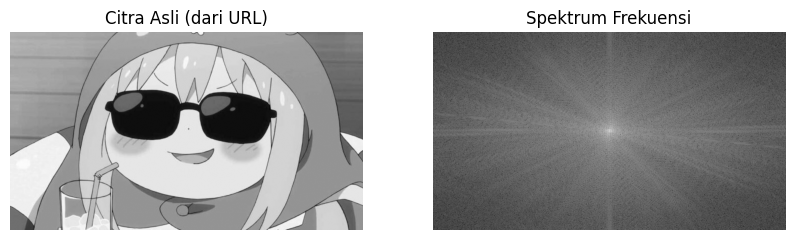

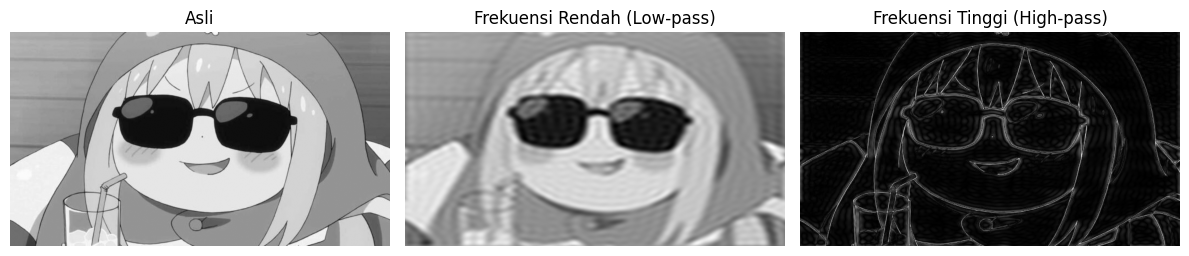

In [15]:
# --- 1. Fungsi FFT dan Spektrum ---
def compute_fft_and_magnitude(img):
    """Menghitung FFT 2D dan magnitudo spektrum yang di-shift."""
    F = np.fft.fft2(img)
    Fshift = np.fft.fftshift(F)
    magnitude = 20 * np.log(np.abs(Fshift) + 1)
    return Fshift, magnitude

# --- 2. Fungsi Filterisasi ---
def apply_filter(Fshift, mask):
    """Menerapkan mask pada spektrum frekuensi dan menghitung IFFT."""
    filtered_freq = Fshift * mask
    img_filtered = np.fft.ifft2(np.fft.ifftshift(filtered_freq))
    return np.abs(img_filtered)

# --- 3. Implementasi Utama ---
img_asli = read_image_from_url(URL_gambar, is_grayscale=True)

print("--- Menjalankan FFT Dasar dan Filtering ---")
if img_asli is None:
    print("Pengolahan dibatalkan.")
else:
    Fshift, magnitude = compute_fft_and_magnitude(img_asli)
    rows, cols = img_asli.shape
    crow, ccol = rows // 2, cols // 2

    # Low-pass Mask
    mask_low = np.zeros((rows, cols), np.uint8)
    mask_low[crow - 30:crow + 30, ccol - 30:ccol + 30] = 1
    img_low = apply_filter(Fshift, mask_low)

    # High-pass Mask
    mask_high = 1 - mask_low
    img_high = apply_filter(Fshift, mask_high)

    # Plot Hasil Spektrum
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1); plt.imshow(img_asli, cmap='gray');
    plt.title("Citra Asli (dari URL)"); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(magnitude, cmap='gray');
    plt.title("Spektrum Frekuensi"); plt.axis('off')
    plt.show()

    # Plot Hasil Filter
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(img_asli, cmap='gray');
    plt.title("Asli"); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(img_low, cmap='gray');
    plt.title("Frekuensi Rendah (Low-pass)"); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(img_high, cmap='gray');
    plt.title("Frekuensi Tinggi (High-pass)"); plt.axis('off')
    plt.tight_layout()
    plt.show()

##2. Homomorphic Filtering

<>:65: SyntaxWarning: invalid escape sequence '\g'
<>:65: SyntaxWarning: invalid escape sequence '\g'
<>:65: SyntaxWarning: invalid escape sequence '\g'
<>:65: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3969790538.py:65: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f'Homomorphic $\gamma L$={gammaL}, $\gamma H$={gammaH}, $D0$={D0}');
/tmp/ipython-input-3969790538.py:65: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f'Homomorphic $\gamma L$={gammaL}, $\gamma H$={gammaH}, $D0$={D0}');



--- Menjalankan Homomorphic Filtering ---


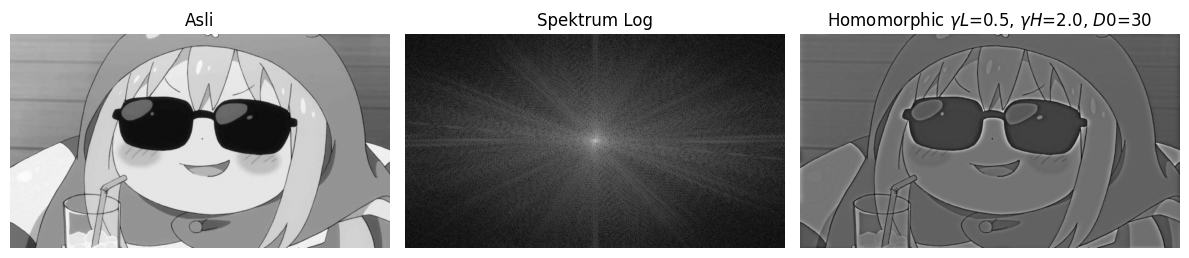

In [16]:
# --- 1. Parameter Filter Homomorphic ---
D0 = 30        # Radius cut-off
gammaL = 0.5
gammaH = 2.0
c = 1.0

# --- 2. Fungsi Implementasi Homomorphic Filtering ---
def homomorphic_filter(img_asli, D0, gammaL, gammaH, c):
    rows, cols = img_asli.shape

    # Normalisasi dan Transformasi Logaritmik
    img_f = img_asli.astype(np.float32)
    img_n = (img_f - img_f.min()) / (img_f.max() - img_f.min())
    logI = np.log1p(img_n)

    # FFT + Shift
    G = np.fft.fft2(logI)
    G_shift = np.fft.fftshift(G)

    # Membuat Fungsi Transfer Filter H(u,v)
    crow, ccol = rows // 2, cols // 2
    u = np.arange(rows) - crow
    v = np.arange(cols) - ccol
    U, V = np.meshgrid(u, v, indexing='ij')
    D_squared = U**2 + V**2

    # Rumus Filter Gaussian High-pass Homomorphic
    H_homo = (
        (gammaH - gammaL)
        * (1.0 - np.exp(-c * (D_squared) / (D0**2)))
        + gammaL
    )

    # Filtering, IFFT, dan Transformasi Eksponensial
    S_shift = H_homo * G_shift
    s = np.fft.ifft2(np.fft.ifftshift(S_shift))
    s = np.real(s)
    g_homo = np.expm1(s)

    # Normalisasi Akhir
    g_homo = (g_homo - g_homo.min()) / (g_homo.max() - g_homo.min())

    return g_homo, G_shift

# --- 3. Implementasi Utama ---
img_asli = read_image_from_url(URL_gambar, is_grayscale=True)

print("\n--- Menjalankan Homomorphic Filtering ---")
if img_asli is None:
    print("Pengolahan dibatalkan.")
else:
    img_homo, G_shift = homomorphic_filter(img_asli, D0, gammaL, gammaH, c)

    # Plot Hasil
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1);
    plt.imshow(img_asli, cmap='gray'); plt.title('Asli'); plt.axis('off')

    plt.subplot(1, 3, 2);
    plt.imshow(np.log1p(np.abs(G_shift)), cmap='gray');
    plt.title('Spektrum Log'); plt.axis('off')

    plt.subplot(1, 3, 3);
    plt.imshow(img_homo, cmap='gray');
    plt.title(f'Homomorphic $\gamma L$={gammaL}, $\gamma H$={gammaH}, $D0$={D0}');
    plt.axis('off')

    plt.tight_layout()
    plt.show()

##3. Phase Correlation (Deteksi Pergeseran)


--- Menjalankan Phase Correlation ---
Peringatan: Ukuran Frame 2 (371x929) diubah ukurannya menjadi Frame 1 (248x600) piksel.
Pergeseran (dy, dx): (-2.00, -10.00)
Deteksi --> Arah: hor=kanan (10.0px), vert=turun (2.0px)


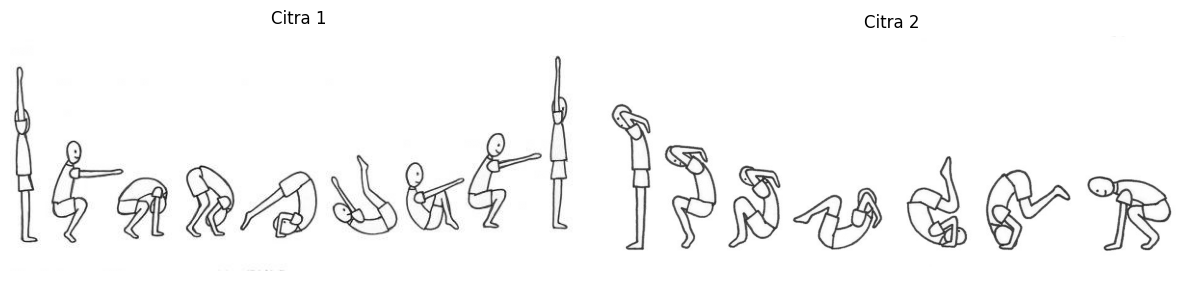

In [19]:
# --- 1. Fungsi Pra-pemrosesan (Edge Detection) ---
def preprocess_for_motion(img):
    """Mendeteksi tepi dengan Canny dan menghaluskan dengan Gaussian Blur."""
    e = cv2.Canny(img, 80, 160)
    e = cv2.GaussianBlur(e, (3, 3), 0)
    return e.astype(np.float32)

# --- 2. Fungsi Phase Correlation ---
def phase_corr_shift(f1, f2):
    """Menghitung pergeseran (dy, dx) antara dua citra menggunakan Phase Correlation."""

    # Memastikan tipe data float
    f1 = f1.astype(np.float32); f2 = f2.astype(np.float32)

    # Windowing (Hanning Window)
    wy = np.hanning(f1.shape[0]); wx = np.hanning(f1.shape[1])
    win = np.outer(wy, wx).astype(np.float32)

    # Perkalian (Hanning Window) - TIDAK AKAN ERROR KARENA f1 dan f2 sudah sama ukuran
    f1_w = f1 * win; f2_w = f2 * win

    # FFT
    F1 = np.fft.fft2(f1_w); F2 = np.fft.fft2(f2_w)

    # Hitung Matriks Korelasi Fase R
    F_product = F2 * np.conj(F1)
    R = F_product / (np.abs(F_product) + 1e-12)

    # IFFT dari R
    r = np.abs(np.fft.ifft2(R))

    # Cari lokasi puncak
    maxloc = np.unravel_index(np.argmax(r), r.shape)
    rows, cols = f1.shape
    py, px = maxloc

    # Hitung Pergeseran
    dy = py if py < rows / 2 else py - rows
    dx = px if px < cols / 2 else px - cols
    return float(dy), float(dx)

# --- 3. Implementasi Utama ---
img1 = read_image_from_url(URL_FRAME1, is_grayscale=True)
img2 = read_image_from_url(URL_FRAME2, is_grayscale=True)

print("\n--- Menjalankan Phase Correlation ---")
if img1 is None or img2 is None:
    print("Pengolahan dibatalkan. Pastikan kedua URL frame valid.")
else:
    e1 = preprocess_for_motion(img1)
    e2 = preprocess_for_motion(img2)

    # >>> START PERBAIKAN UKURAN (SIZE ENFORCEMENT) <<<
    H1, W1 = e1.shape
    H2, W2 = e2.shape

    if H1 != H2 or W1 != W2:
        # Resize e2 agar ukurannya sesuai dengan e1
        e2 = cv2.resize(e2, (W1, H1), interpolation=cv2.INTER_AREA)
        print(f"Peringatan: Ukuran Frame 2 ({H2}x{W2}) diubah ukurannya menjadi Frame 1 ({H1}x{W1}) piksel.")
    # >>> END PERBAIKAN UKURAN (SIZE ENFORCEMENT) <<<


    # Hitung Pergeseran
    shift_y, shift_x = phase_corr_shift(e1, e2)
    print(f"Pergeseran (dy, dx): ({shift_y:.2f}, {shift_x:.2f})")

    # Analisis Arah
    move_h = "kiri" if shift_x > 0 else "kanan" if shift_x < 0 else "tidak ada perubahan"
    move_v = "naik" if shift_y > 0 else "turun" if shift_y < 0 else "tidak ada perubahan"
    print(f"Deteksi --> Arah: hor={move_h} ({abs(shift_x):.1f}px), vert={move_v} ({abs(shift_y):.1f}px)")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1); plt.imshow(img1, cmap='gray');
    plt.title('Citra 1'); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(img2, cmap='gray');
    plt.title('Citra 2'); plt.axis('off')
    plt.tight_layout(); plt.show()

##4. Analisis dan Deteksi Pola Frekuensi (Tekstur)


--- Menjalankan Analisis Pola Frekuensi ---


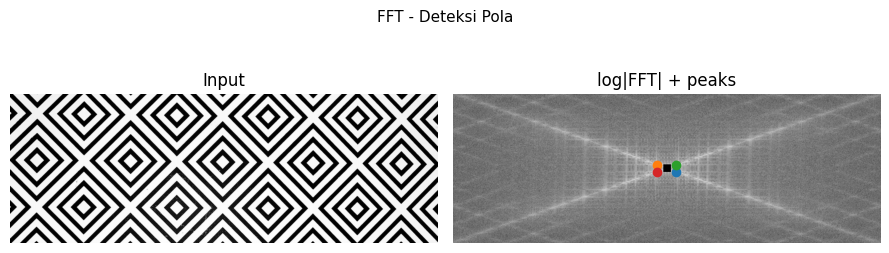


Metrik Pola yang Terdeteksi:
 rank  period_px  angle_spatial_deg
    1     15.135             109.65
    2     15.135              70.35


In [20]:
# --- 1. Fungsi Pembantu ---
def hann2d(h, w):
    """Menghasilkan Hanning Window 2D."""
    wy = np.hanning(h); wx = np.hanning(w)
    return np.outer(wy, wx).astype(np.float32)

def compute_fft_logmag(gray):
    """Menghitung FFT, Shift, dan Log Magnitude."""
    H, W = gray.shape
    g = gray.astype(np.float32) - float(np.mean(gray))
    gw = g * hann2d(H, W)
    F = np.fft.fft2(gw)
    Fs = np.fft.fftshift(F)
    logmag = np.log1p(np.abs(Fs))
    center = (H // 2, W // 2)
    return logmag, Fs, center

def suppress_dc(logmag, center, radius=11):
    """Mengatur area pusat (DC) spektrum menjadi nol."""
    cy, cx = center; H, W = logmag.shape
    out = logmag.copy()
    y0, y1 = max(0, cy - radius), min(H, cy + radius + 1)
    x0, x1 = max(0, cx - radius), min(W, cx + radius + 1)
    out[y0:y1, x0:x1] = 0.0
    return out

# --- 2. Fungsi Deteksi Puncak Pola ---
def greedy_peaks(logmag, center, topk=4, min_dist=7):
    """Mendeteksi puncak frekuensi dominan menggunakan filter serakah."""
    H, W = logmag.shape; cy, cx = center
    flat = logmag.ravel(); k = min(topk * 12, flat.size)
    idxs = np.argpartition(flat, -k)[-k:]
    ys, xs = np.unravel_index(idxs, logmag.shape)
    vals = logmag[ys, xs]; order = np.argsort(-vals)

    sel = []
    for i in order:
        y, x = int(ys[i]), int(xs[i])
        if all((y - yy)**2 + (x - xx)**2 >= min_dist**2 for (yy, xx) in sel):
            sel.append((y, x))
        if len(sel) >= topk * 2: break

    # Filter Setengah Bidang (Simetri Hermetian)
    half = []
    for (y, x) in sel:
        dy, dx = y - cy, x - cx
        if dy == 0 and dx == 0: continue
        if (dx > 0) or (dx == 0 and dy > 0):
            half.append((dy, dx))

    half = sorted(half, key=lambda p: float(np.hypot(p[0], p[1])))[:topk]
    return half

# --- 3. Fungsi Metrik dan Plotting ---
def show_metrics(peaks, H, W):
    """Menghitung dan menampilkan metrik pola (periode & sudut spasial)."""
    S = min(H, W)
    records = []
    for i, (dy, dx) in enumerate(peaks, 1):
        r = np.hypot(dy, dx)
        period = S / r if r > 0 else 0
        angle_f = np.degrees(np.arctan2(dy, dx))
        angle_s = (angle_f + 90) % 180
        records.append({
            "rank": i,
            "period_px": round(period, 3),
            "angle_spatial_deg": round(angle_s, 2)
        })
    return pd.DataFrame(records)

def show_plot_with_peaks(img, logmag, center, peaks, title):
    """Menampilkan citra input dan spektrum dengan puncak yang terdeteksi."""
    cy, cx = center
    plt.figure(figsize=(9, 3))

    ax1 = plt.subplot(1, 2, 1);
    ax1.imshow(img, cmap='gray'); ax1.set_title("Input"); ax1.axis('off')

    ax2 = plt.subplot(1, 2, 2);
    ax2.imshow(logmag, cmap='gray')

    for (dy, dx) in peaks:
        y, x = cy + dy, cx + dx
        ax2.plot([x], [y], 'o', markersize=6) # Puncak
        ax2.plot([2 * cx - x], [2 * cy - y], 'o', markersize=6) # Puncak Simetris

    ax2.set_title("log|FFT| + peaks"); ax2.axis('off')
    plt.suptitle(title, fontsize=11); plt.tight_layout(); plt.show()

# --- 4. Implementasi Utama ---
img = read_image_from_url(URL_PATTERN, is_grayscale=True)

print("\n--- Menjalankan Analisis Pola Frekuensi ---")
if img is None:
    print("Pengolahan dibatalkan.")
else:
    logmag, Fs, center = compute_fft_logmag(img)
    logmag_suppressed = suppress_dc(logmag, center, radius=11)
    peaks = greedy_peaks(logmag_suppressed, center, topk=4, min_dist=7)
    show_plot_with_peaks(img, logmag_suppressed, center, peaks, "FFT - Deteksi Pola")

    H, W = img.shape
    df = show_metrics(peaks, H, W)
    print("\nMetrik Pola yang Terdeteksi:")
    print(df.to_string(index=False))